In [1]:
#import relevant packages for analysis

from __future__ import print_function

import os
import sys

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

PROJ_ROOT = os.path.join(os.pardir)

sns.set()
sns.set_style("darkgrid")
sns.set_context("poster")

In [2]:
%load_ext watermark
%watermark -a "Bryan Dickinson" -d -t -v -p numpy,pandas

Bryan Dickinson 2019-09-23 09:25:31 

CPython 3.7.3
IPython 7.7.0

numpy 1.16.4
pandas 0.25.0


In [3]:
customer_path = os.path.join(PROJ_ROOT, 
                         'data', 'processed',
                         'clean_data.csv')
data = pd.read_csv(customer_path,
                   dtype={'User_ID':'category','Product_ID':'category',
                          'Marital_Status':'category','Gender':'category', 
                          'Age': 'category', 'Occupation':'category', 
                          'Product_Category_1': 'int',
                          'Product_Category_2': 'float',
                          'Product_Category_3':'float', 
                          'City_Category': 'category', 
                          'Stay_In_Current_City_Years': 'category'} )

In [4]:
from sklearn.preprocessing import LabelEncoder, scale
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

In [5]:
df = data#.sample(frac = .35)

In [6]:
def split_mean(x):
    '''A function to split the Age bins and return the mean of the two numbers'''
    if '-' in x:
        split_list = x.split('-')
        mean = (float(split_list[0]) + float(split_list[1]))/2
    else:
        mean = 55
    
    return mean

def clean_city_yr(x):
    ''' A function to clean the stay in curren city years feature by removing the non-numeric symobol'''
    #if x == NaN:
        
    num = x.split('+')[0]
  
    return int(num)

def replace_nan(x):
    if pd.isnull(x):
        x = '0'
    else:
        x = int(x)
    
    if int(x) < 10:
        x = '0' + str(x)
        
    return x

def merge_categories(row):
    
    p_cat_1 = str(row['Product_Category_1'])
    p_cat_2 = str(row['Product_Category_2'])
    p_cat_3 = str(row['Product_Category_3'])
    
    cat = p_cat_1 + p_cat_2 + p_cat_3
    
    #pattern = re.compile('(^\d*)')
    
    #result = pattern.match(cat).group(1)
    
    return cat


In [7]:
customers = df.copy(deep = True)

In [8]:
#remove the nan from each category and replace with '00'
#replace values with a preceding/buffer 0 for categories <10
df['Product_Category_1'] = df.Product_Category_1.apply(lambda x: replace_nan(x))

#rename the category column
df.rename(columns = {'Product_Category_1': 'Product_Categories'}, inplace = True)

#convert features to category types
df['Product_Categories'] = df['Product_Categories'].astype('category')

#merge all product categories together to identify specific items
#df['Product_Categories'] = df.apply(merge_categories, axis = 1)

#Assign cat codes to gender
df['Gender'] = df['Gender'].cat.codes


#Fix Years in city column to numerical
df['_City_Yr'] = df.Stay_In_Current_City_Years.apply(lambda x: clean_city_yr(x))
df = df.drop('Stay_In_Current_City_Years', axis = 1)

#convert age column to numeric
df['_Age'] = df.Age.apply(lambda x: split_mean(x))
df = df.drop('Age', axis = 1)

#get dummies for City & occupation columns
df = pd.get_dummies(df, columns = ['City_Category'], prefix = ['City'])

df = pd.get_dummies(df, columns = ['Occupation'], prefix = ['Occ'])

#rearrange columns
df = df[['Product_Categories','User_ID', 'Gender', 'Marital_Status', '_City_Yr', '_Age',
       'City_A', 'City_B', 'City_C', 'Occ_0', 'Occ_1', 'Occ_10', 'Occ_11',
       'Occ_12', 'Occ_13', 'Occ_14', 'Occ_15', 'Occ_16', 'Occ_17', 'Occ_18',
       'Occ_19', 'Occ_2', 'Occ_20', 'Occ_3', 'Occ_4', 'Occ_5', 'Occ_6',
       'Occ_7', 'Occ_8', 'Occ_9']]


# group by
cat_df = df.copy()
cat_df['n'] = 1
cat_df = cat_df.groupby(['User_ID', 'Product_Categories'])[['n']].count()
cat_df = cat_df.pivot_table(index = 'User_ID', columns = 'Product_Categories', values = 'n', fill_value = 0)

In [9]:
cat_df.head()

Product_Categories,10,11,12,13,14,15,16,17,18,19,20,01,02,03,04,05,06,07,08,09
User_ID,,,,,,,,,,,,,,,,,,,,
1000001,0,0,3,0,1,0,1,0,0,0,1,4,1,11,2,2,1,0,8,0
1000002,0,0,0,0,0,0,0,0,0,0,1,31,1,0,0,13,6,0,25,0
1000003,0,0,0,0,0,0,0,0,1,0,0,15,2,1,0,9,0,0,1,0
1000004,0,0,0,0,0,0,0,0,0,0,1,13,0,0,0,0,0,0,0,0
1000005,0,2,0,0,1,1,3,0,0,0,0,18,2,1,3,20,6,5,44,0


In [10]:
cat_df = cat_df.drop(columns = ['01','05','08'], axis = 1)

In [11]:
#use PCA for determine the optimal amount of dimensions for the dataset
from sklearn.decomposition import PCA

#convert the df columns to a numpy array
x_cols = cat_df.astype('bool')*1
x_cols = scale(x_cols)

In [12]:
pca = PCA() #instantiate PCA
pca.fit(x_cols) #fit the data

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

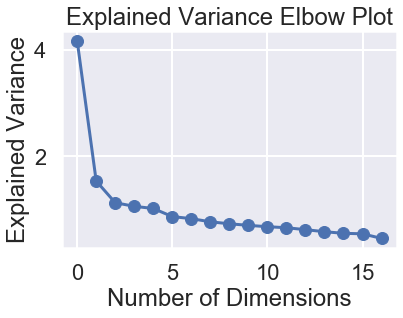

In [13]:
#craete an array equaling the total number of features
comp = range(pca.n_components_)

#the amount of variance explained by each of the selected components
var = pca.explained_variance_

#create a df with the the explained variances
ev = pd.DataFrame({'n_component':comp, 'explained_variance':var})

#plot the components to visualize the elbow point
_=plt.plot(ev.n_component[:20], ev.explained_variance[:20], marker = 'o')
_=plt.title('Explained Variance Elbow Plot')
_=plt.xlabel('Number of Dimensions')
_=plt.ylabel('Explained Variance')

Three clusters are determined from the the Elbow Plot

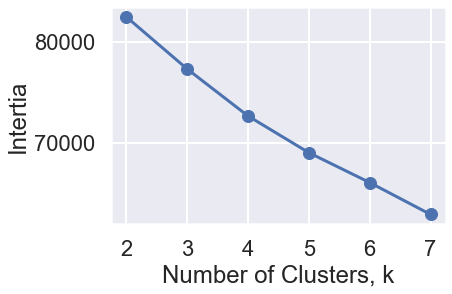

In [14]:
#show the intertia values for different values of K
from sklearn.cluster import KMeans
ks = range(2,8)
inertias = []
for k in ks:
    model = KMeans(n_clusters = k)
    model.fit(x_cols)
    inertias.append(model.inertia_)
#plot the intertias
plt.plot(ks, inertias, '-o')
_=plt.xlabel('Number of Clusters, k')
_=plt.ylabel('Intertia')
_=plt.xticks(ks)
plt.show()



There is a gradual decline when looking at the 'elbow point' via KMeans intertias. We will continue on with using the PCA dimensionality reduction method.

In [15]:
%%time
model = KMeans(n_clusters = 3)
model.fit(x_cols)
labels = model.predict(x_cols)

Wall time: 202 ms


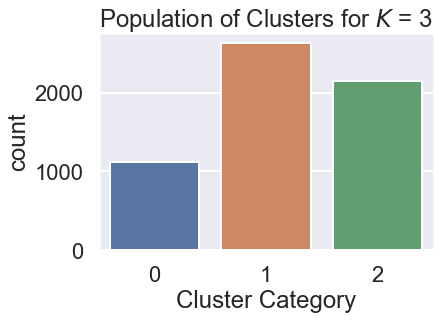

In [16]:
#plot frequncies of the different labels in the dataset
sns.countplot(x = labels)
_=plt.xlabel('Number of Points')
_=plt.xlabel('Cluster Category')
_=plt.title('Population of Clusters for $K$ = 3')

In [17]:
# use PCA to visualize 3 clusters in a 2d graph
pca = PCA(n_components = 2)
pca.fit(x_cols)
pca.transform(x_cols)
transformed = pca.transform(x_cols)

In [18]:
#build the new df with the principal components, customer data and labels
c_df = pd.DataFrame({'x': transformed[:,0],
                   'y': transformed[:,1],
                   'cluster': labels},
                  index = cat_df.index)

In [19]:
c_df.head()

,x,y,cluster
User_ID,,,
1000001,0.401187,-1.315968,2
1000002,-2.280552,-1.317121,1
1000003,-1.710340,0.096376,1
1000004,-3.440306,-1.310129,1
1000005,1.591674,0.217895,2


C:\Users\Bryan\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


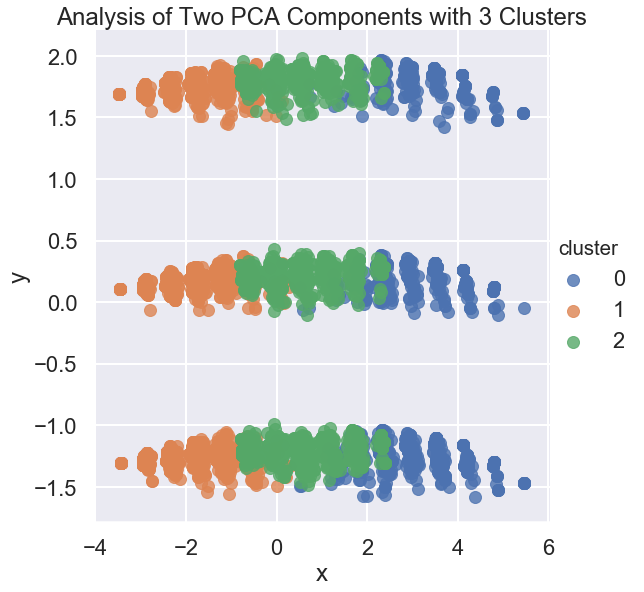

In [20]:
#plot the datapoints
_=sns.lmplot(x = 'x',
             y='y',
             data = c_df,
             fit_reg = False,
             hue = 'cluster',
             size = 8)
_=plt.title('Analysis of Two PCA Components with 3 Clusters')

Given the high dimensionality of the dataset, it is difficult to visualize the data in two dimensions.

In [21]:
#combine the labels with the original dataset
combined = pd.merge(c_df, customers, on = 'User_ID')
del combined['x']
del combined['y']

In [22]:
combined.head()

,User_ID,cluster,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,2,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,2,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,2,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,2,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000001,2,P00085942,F,0-17,10,A,2,0,2,4.0,8.0,12842


In [23]:
#display the categorical variables with the different clusters
list_dfs = {}
col_list = ['Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1']
for col in combined.columns:
    if col in col_list:
        temp_df = combined.groupby('cluster')[col].value_counts(normalize = True).unstack(1)
        list_dfs[col] = temp_df


In [24]:
for df in list_dfs.values():
    display (df)

Gender,F,M
cluster,,
0,0.217294,0.782706
1,0.320878,0.679122
2,0.252621,0.747379


Age,0-17,18-25,26-35,36-45,46-50,51-55,55+
cluster,,,,,,,
0,0.014778,0.157413,0.411208,0.221391,0.087280,0.075828,0.032101
1,0.048548,0.170454,0.329584,0.190663,0.083941,0.094921,0.081889
2,0.034765,0.217938,0.415042,0.175619,0.077064,0.050740,0.028832


Occupation,0,1,10,11,12,13,14,15,16,17,...,19,2,20,3,4,5,6,7,8,9
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.131733,0.087710,0.012246,0.022312,0.041153,0.009311,0.040341,0.023747,0.056300,0.055620,...,0.016798,0.053517,0.079375,0.036536,0.131391,0.024628,0.039190,0.115801,NaN,0.010286
1,0.121053,0.084351,0.038931,0.021041,0.053184,0.033652,0.057055,0.022349,0.035260,0.077596,...,0.012944,0.041904,0.041072,0.026298,0.117626,0.020175,0.037323,0.123027,0.003172,0.022360
2,0.122263,0.085077,0.031519,0.019400,0.079094,0.011407,0.058718,0.019822,0.037471,0.093609,...,0.014602,0.044345,0.045561,0.028781,0.137878,0.019700,0.033930,0.089259,0.006411,0.007967


City_Category,A,B,C
cluster,,,
0,0.370492,0.502521,0.126987
1,0.154904,0.238501,0.606595
2,0.184085,0.393420,0.422496


Stay_In_Current_City_Years,0,1,2,3,4+
cluster,,,,,
0,0.144605,0.346973,0.175487,0.18037,0.152564
1,0.129627,0.356681,0.204284,0.15456,0.154849
2,0.125301,0.357592,0.189284,0.17221,0.155614


Marital_Status,0,1
cluster,,
0,0.578148,0.421852
1,0.568984,0.431016
2,0.616491,0.383509


Product_Category_1,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
cluster,,,,,,,,,,,,,,,,,,,,
0,0.229167,0.045281,0.034045,0.021104,0.271885,0.037413,0.008403,0.225199,0.000961,0.010313,0.045543,0.009185,0.012162,0.003907,0.012409,0.019737,0.001724,0.008513,0.001059,0.001990
1,0.291940,0.035260,0.037046,0.020042,0.285784,0.032964,0.004570,0.197063,0.000233,0.006045,0.034617,0.006211,0.004381,0.002152,0.004969,0.011835,0.000743,0.003538,0.007553,0.013055
2,0.273232,0.044569,0.040229,0.022325,0.272520,0.038875,0.005576,0.187483,0.000692,0.009484,0.046665,0.004925,0.009926,0.001526,0.013096,0.018128,0.000290,0.002869,0.003271,0.004319


#### Noticeable initial differences in the clusters:
**Cluster 1** has a higher proportion of female customers compared to clusters 0 and 2 (though the majority is still Male).

**City Category:**
- Cluster 1 61% of population is located in City Category C
- Cluster 0 half of the population is located in City Category B

In [25]:

# display the top 3 
for cluster in range(3):
    print('Counts for top 3 options in occupation & product category for cluster: ', cluster)
    for col in ['Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years','Product_Category_1']:
        display(pd.DataFrame(combined[combined.cluster == cluster][col].astype('category').value_counts(normalize= True)[:6]))

Counts for top 3 options in occupation & product category for cluster:  0


,Age
26-35,0.411208
36-45,0.221391
18-25,0.157413
46-50,0.087280
51-55,0.075828
55+,0.032101


,Occupation
0,0.131733
4,0.131391
7,0.115801
1,0.087710
20,0.079375
16,0.056300


,City_Category
B,0.502521
A,0.370492
C,0.126987


,Stay_In_Current_City_Years
1,0.346973
3,0.180370
2,0.175487
4+,0.152564
0,0.144605


,Product_Category_1
5,0.271885
1,0.229167
8,0.225199
11,0.045543
2,0.045281
6,0.037413


Counts for top 3 options in occupation & product category for cluster:  1


,Age
26-35,0.329584
36-45,0.190663
18-25,0.170454
51-55,0.094921
46-50,0.083941
55+,0.081889


,Occupation
7,0.123027
0,0.121053
4,0.117626
1,0.084351
17,0.077596
14,0.057055


,City_Category
C,0.606595
B,0.238501
A,0.154904


,Stay_In_Current_City_Years
1,0.356681
2,0.204284
4+,0.154849
3,0.154560
0,0.129627


,Product_Category_1
1,0.291940
5,0.285784
8,0.197063
3,0.037046
2,0.035260
11,0.034617


Counts for top 3 options in occupation & product category for cluster:  2


,Age
26-35,0.415042
18-25,0.217938
36-45,0.175619
46-50,0.077064
51-55,0.050740
0-17,0.034765


,Occupation
4,0.137878
0,0.122263
17,0.093609
7,0.089259
1,0.085077
12,0.079094


,City_Category
C,0.422496
B,0.393420
A,0.184085


,Stay_In_Current_City_Years
1,0.357592
2,0.189284
3,0.172210
4+,0.155614
0,0.125301


,Product_Category_1
1,0.273232
5,0.272520
8,0.187483
11,0.046665
2,0.044569
3,0.040229


**Age**
- Clusters 0 & 1 have Age ranges of 26-35 & 36-45 their top 2 age categories
- Cluster 2 has the age range of 18-25 as their second highest frequency age range

**Occupation**
 - All clusters have occupations 0, 4, 7 in their top 4 occupations
 - The occupations for the number 4 - 6 spots are very different between clusters
     - For example: Cluster 2, occupation 17 takes the third top spot, which is 5 for cluster 1 and not listed in the top 6 for cluster 0
     - These categories may be able to tease out & target different segments of customer for more strategic marketing. The challenge is the fact that after the top three occupation categories. The remaining 2/3 of the data is spread among many categories. The fifth occupation category for cluster 1 has a frequency of 5%.
     
**City Category**
- Clusters 0 and 1 have very different top city categories (B & C respectivley). 

**Stay in Current City**
- Each clusters' majority of customers fall into '1' year of staying in the current city. However, after that first year, there is more variability among the groups. 
     - Three years is cluster 0's second most frequent customer (18%)
     - Two years is cluster 1's second most frequent customer (20%)
     - Cluster 2 has the highest proportion of '1' year customers at 36%
     
**Product Category**
- For all clusters the categories 8,5,1 are the top 3 most purchased categories
- Cluster 0's top category is 5, and for clusters 1 and 2, the top category is 1.
- There is more variability for the next 3 categories, however, frequency drops dramatically to ~ 4% after the 3rd category

More information is needed for categories 1, 5 & 8. If these are products that many people purchase (ie. milk/eggs) it may not show a lot of difference among categories. To get better insight and reach a more personalized approach, repeating this process with these 3 categories removed, may give some more insight into growing sales outside of these three categories.